In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

K = 10
T = np.int(5e3)
true_theta = np.array([[-1], [-1], [3]])
phi = np.hstack((np.linspace(0, 5, K).reshape(-1, 1), np.linspace(-3, 1, K).reshape(-1, 1)**2, np.ones((K, 1))))
true_reward = phi.dot(true_theta)

def draw_reward(arm, phi, theta, sigma):
    """
    Generating reward for each arm
    """
    # print("rand : ", np.random.randn())
    return np.dot(phi[arm], theta) + sigma*np.random.randn()

# LinUCB

In [101]:
# def compute_quantities(phi, a, R, t, lambda_ = 0):
#     matrix = np.einsum('ij,ik->jk', phi[a[:t]],  phi[a[:t]]) + lambda_*np.eye(phi.shape[1])
#     b = np.sum(phi[a[:t]] * R[:t, None], axis = 0)
#     inv = np.linalg.inv(matrix)
#     theta = inv.dot(b)
#     return theta[:, None], phi.dot(theta).reshape(-1) , inv

def compute_quantities(phi, a, R, t, lambda_):
    matrix = np.multiply(phi[a[:t]][:,:,np.newaxis], phi[a[:t]][:,np.newaxis, :]).sum(axis=0)+ lambda_*np.eye(phi.shape[1])
    b = np.sum(phi[a[:t]] * R[:t, None], axis = 0)
    inv = np.linalg.inv(matrix)
    theta = inv.dot(b)
    return theta[:, None], phi.dot(theta).reshape(-1) , inv

def choose_arm_ucb(mu_estim, phi, inv, alpha):
    """
    Choose arm with gumbel uncertainty
    """
#     print(inv)
#     print((phi).dot(inv.dot(phi.T)))
    I = mu_estim + alpha * np.multiply(phi.dot(inv), phi).sum(axis=1)
#     I = mu_estim + alpha * np.sqrt((phi).dot(inv.dot(phi.T)))
#     print(I)
    return np.argmax(I)

def bandit_ucb(K, T, phi, true_theta, sigma,  alpha, training_ini = 100, lambda_= 0):
    """
    Simulate bandit algorithm
    """
    # Cumulative reward for each arm
    R = np.zeros(T)
    # Number of time armed pulled
    N = np.zeros(K)
    # Stored actions
    a = -1 * np.ones(T, dtype=np.int)
    list_estimates = []
    # Expected true reward
    true_reward = phi.dot(true_theta)
    Regret = np.zeros(T+1)
    # L2 distance for theta
    L2_dist = np.zeros(T)
    theta_estimate = np.random.randn(phi.shape[1], 1)
    list_estimates = [theta_estimate]
    L2_dist[0] = np.linalg.norm(theta_estimate - true_theta, ord = 2)
    for t in range(T):
        if t > training_ini: 
            theta_estimate, mu_estim, inv = compute_quantities(phi, a, R, t=t, lambda_ = lambda_)
            list_estimates.append(theta_estimate)
            arm = choose_arm_ucb(mu_estim, phi, inv, alpha)
            
            # update parameters:
        else :
            arm = np.random.randint(K)
        # Observe reward:
        reward = draw_reward(arm, phi, true_theta, sigma)
        N[arm] += 1
        R[t] = reward
        a[t] = arm
        Regret[t+1] = Regret[t] + np.max(true_reward) - true_reward[arm]

        L2_dist[t] = np.linalg.norm(theta_estimate - true_theta, ord = 2)

        Regret[t+1] = Regret[t] + np.max(true_reward) - true_reward[arm]

    return theta_estimate, N, R, Regret, L2_dist, a, list_estimates


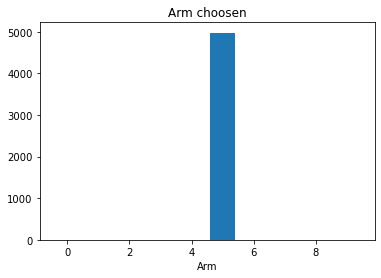

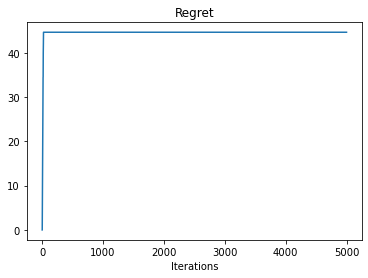

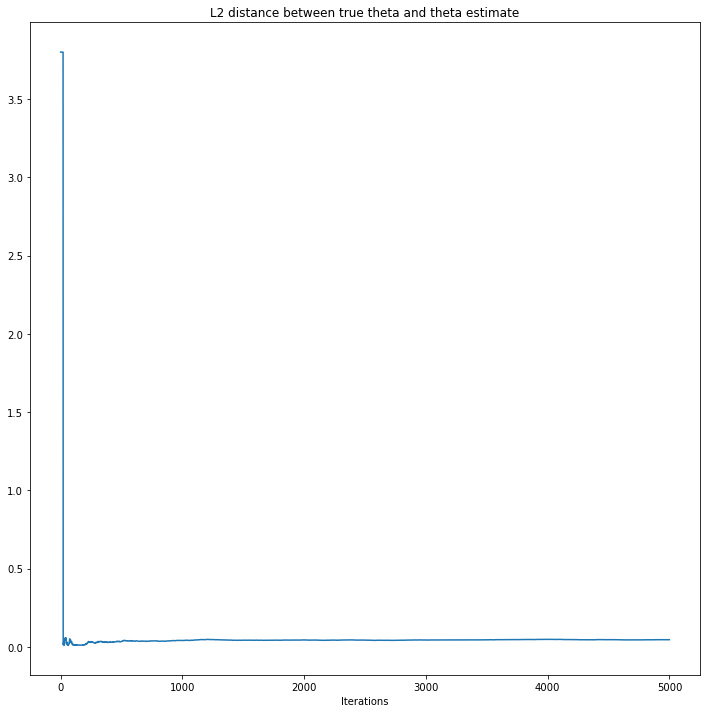

In [104]:
theta_estimate, N, R, Regret, L2_dist, a, list_estimates = bandit_ucb(K, T, phi, true_theta, alpha = 5, sigma = 0.1, training_ini = 20, lambda_ = 0.01)

plt.bar(range(len(N)), N)
plt.title('Arm choosen')
plt.xlabel('Arm')
plt.show()


plt.plot(Regret)
plt.title('Regret')
plt.xlabel('Iterations')
plt.show()


plt.figure(figsize=(12,12))
plt.plot(L2_dist[L2_dist>0])
plt.title('L2 distance between true theta and theta estimate')
plt.xlabel('Iterations')
plt.show()

# SGD methods : 

In [3]:
def gradient(theta, t, phi, lambda_, r, a, training_ini):
    """
    Return gradient of the objective function
    """
    fact = (phi[a[t+1 - training_ini:t+1 ]].dot(theta) - r[t+1 - training_ini:t+1 ][:, None])
    return 2 * np.einsum('ij,ik->k', fact, phi[a[t+1 - training_ini:t+1 ]])[:, None]/ training_ini  + 2*lambda_*theta
    #return 2/(training_ini)*(fact * phi[a[t+1 - training_ini:t+1 ]]).sum(axis=0).reshape(3, 1)
    
def update_theta(theta_estimate, t, phi, a, R, nu, n_iter, training_ini, lambda_):
    """
    Update the estimate of theta with gradient descent
    """
    for _ in range(n_iter):
        theta_estimate = theta_estimate - nu * gradient(theta_estimate, t, phi, lambda_, R, a, training_ini)
    return theta_estimate

# BGE-SGD

In [4]:
def BGE(C, N, K):
    """
    Return eta, beta for the BGE scheduler
    """
    beta = C * np.ones(K)
    for j in range(K):
        if N[j]>0:
            beta[j] = np.sqrt(C**2 / N[j])
    return 1, beta, True

def choose_arm(theta_estimate, phi, eta, beta, sampling_gumbel):
    """
    Choose arm with gumbel uncertainty
    """
    K, d = phi.shape
    mu = np.dot(phi, theta_estimate).reshape(-1)
    gum = np.ones(K)
    if sampling_gumbel:
        for j in range(K):
            gum[j] = np.random.gumbel(loc=0, scale=1)
    
    I = beta * gum + eta * mu
    return np.argmax(I)

def bandit(K, T, phi, C, true_theta, nu, sigma, training_ini = 100, lambda_= 0):
    """
    Simulate bandit algorithm
    """
    # Cumulative reward for each arm
    R = np.zeros(T)
    # Number of time armed pulled
    N = np.zeros(K)
    # Stored actions
    a = -1 * np.ones(T, dtype=np.int)
    list_estimates = []
    # Expected true reward
    true_reward = phi.dot(true_theta)
    Regret = np.zeros(T+1)
    # L2 distance for theta
    L2_dist = np.zeros(T)

    for t in range(training_ini):
        eta, beta, sampling_gumbel = BGE(C, N, K)
        arm = np.random.randint(K)
         # Observe reward:
        reward = draw_reward(arm, phi, true_theta, sigma)
        # update parameters:
        N[arm] += 1
        R[t] = reward
        a[t] = arm
        Regret[t+1] = Regret[t] + np.max(true_reward) - true_reward[arm]

    theta_avg = phi[a[:training_ini]].dot(phi[a[:training_ini]].T)
    matrix = np.einsum('ij,ik->jk', phi[a[:training_ini]],  phi[a[:training_ini]]) + lambda_*np.eye(phi.shape[1])
    b = np.sum(phi[a[:training_ini]] * R[:training_ini][:, None], axis = 0)
    theta_avg = np.linalg.inv(matrix).dot(b)
    theta_estimate = theta_avg.copy()[:, None]
    L2_dist[training_ini - 1 ] = np.linalg.norm(theta_avg[:, None] - true_theta, ord = 2)

    for t in range(t + 1, T):
        # Uncertainty :
        eta, beta, sampling_gumbel = BGE(C, N, K)
        # Choose arm:
        arm = choose_arm(theta_avg, phi, eta, beta, sampling_gumbel)
        # Observe reward:
        reward = draw_reward(arm, phi, true_theta, sigma)
        # update parameters:
        N[arm] += 1
        R[t] = reward
        a[t] = arm

        # Estimate theta
        if t%training_ini == 0: 
            theta_estimate = update_theta(theta_estimate, t, phi, a, R, nu = nu/(t // training_ini), n_iter = 1, training_ini = training_ini, lambda_ = lambda_)
            list_estimates.append(theta_estimate)
            theta_avg = np.mean(list_estimates, axis = 0)
            # L2 distance:
            L2_dist[t] = np.linalg.norm(theta_avg - true_theta, ord = 2)
        # update regret (average)
        Regret[t+1] = Regret[t] + np.max(true_reward) - true_reward[arm]


    return theta_estimate, N, R, Regret, L2_dist, a

# KL-SGD

In [5]:
def choose_arm_kl(theta_estimate, phi, N, t, sigma):
    """
    Choose arm with gumbel uncertainty
    """
    K, d = phi.shape
    mu = np.dot(phi, theta_estimate).reshape(-1)
    
    I = np.ones(K)
    for j in range(K):
        I[j] = mu[j] + np.sqrt(2*sigma**2*np.log(1 + t*np.log(t)**2) / N[j])
    return np.argmax(I)

def bandit_kl(K, T, phi, true_theta, nu, sigma=0.5, training_ini = 100, lambda_= 0):
    """
    Simulate bandit algorithm
    """
    # Cumulative reward for each arm
    R = np.zeros(T)
    # Number of time armed pulled
    N = np.zeros(K)
    # Stored actions
    a = -1 * np.ones(T, dtype=np.int)
    list_estimates = []
    # Expected true reward
    true_reward = phi.dot(true_theta)
    Regret = np.zeros(T+1)
    # L2 distance for theta
    L2_dist = np.zeros(T)

    for t in range(training_ini):
        arm = np.random.randint(K)
         # Observe reward:
        reward = draw_reward(arm, phi, true_theta, sigma)
        # update parameters:
        N[arm] += 1
        R[t] = reward
        a[t] = arm
        Regret[t+1] = Regret[t] + np.max(true_reward) - true_reward[arm]

    theta_avg = phi[a[:training_ini]].dot(phi[a[:training_ini]].T)
    matrix = np.einsum('ij,ik->jk', phi[a[:training_ini]],  phi[a[:training_ini]]) + lambda_*np.eye(phi.shape[1])
    b = np.sum(phi[a[:training_ini]] * R[:training_ini][:, None], axis = 0)
    theta_avg = np.linalg.inv(matrix).dot(b)
    theta_estimate = theta_avg.copy()[:, None]
    L2_dist[training_ini - 1 ] = np.linalg.norm(theta_avg[:, None] - true_theta, ord = 2)

    for t in range(t + 1, T):
        # Choose arm:
        arm = choose_arm_kl(theta_avg, phi, N, t, sigma)
        # Observe reward:
        reward = draw_reward(arm, phi, true_theta, sigma)
        # update parameters:
        N[arm] += 1
        R[t] = reward
        a[t] = arm
        
        # Estimate theta
        if t%training_ini == 0: 
            theta_estimate = update_theta(theta_estimate, t, phi, a, R, nu = nu/(t // training_ini), n_iter = 1, training_ini = training_ini, lambda_ = lambda_)
            list_estimates.append(theta_estimate)
            theta_avg = np.mean(list_estimates, axis = 0)
            # L2 distance:
            L2_dist[t] = np.linalg.norm(theta_avg - true_theta, ord = 2)
        # update regret (average)
        Regret[t+1] = Regret[t] + np.max(true_reward) - true_reward[arm]
    return theta_estimate, N, R, Regret, L2_dist, a


# TS-SGD


In [74]:
def choose_arm_ts(phi, t, training_ini, T, theta_avg, nu, sigma):
    """
    Choose arm with gumbel uncertainty
    """
    d = phi.shape[1]
    alpha = 1/nu
    g1 = sigma**2*np.sqrt(0.5*d*np.log(1 + 2 * t * training_ini/d) + 2*np.log(T))
    g2 = ( training_ini / alpha ) * np.sqrt(1 + np.log(t))
    A = (2*g1**2/( alpha * t ) + 2 * g2**2 / t)*np.eye(d)
    epsilon = np.random.multivariate_normal(np.zeros(d), A)[:, None]
    theta_ts = theta_avg + epsilon
    return np.argmax(np.squeeze(phi.dot(theta_ts)))

def bandit_ts(K, T, phi, true_theta, nu, sigma, training_ini = 100, lambda_= 0):
    """
    Simulate bandit algorithm
    """
    # Cumulative reward for each arm
    R = np.zeros(T)
    # Number of time armed pulled
    N = np.zeros(K)
    # Stored actions
    a = -1 * np.ones(T, dtype=np.int)
    list_estimates = []
    # Expected true reward
    true_reward = phi.dot(true_theta)
    Regret = np.zeros(T+1)
    # L2 distance for theta
    L2_dist = np.zeros(T)

    for t in range(training_ini):
        arm = np.random.randint(K)
         # Observe reward:
        reward = draw_reward(arm, phi, true_theta, sigma)
        # update parameters:
        N[arm] += 1
        R[t] = reward
        a[t] = arm
        Regret[t+1] = Regret[t] + np.max(true_reward) - true_reward[arm]

    theta_avg = phi[a[:training_ini]].dot(phi[a[:training_ini]].T)
    matrix = np.einsum('ij,ik->jk', phi[a[:training_ini]],  phi[a[:training_ini]]) + lambda_*np.eye(phi.shape[1])
    b = np.sum(phi[a[:training_ini]] * R[:training_ini][:, None], axis = 0)
    theta_avg = np.linalg.inv(matrix).dot(b)[:, None]
    theta_estimate = theta_avg.copy()
    L2_dist[training_ini - 1 ] = np.linalg.norm(theta_avg - true_theta, ord = 2)

    for t in range(t + 1, T):
        # Choose arm:
        arm = choose_arm_ts(phi, t, training_ini, T, theta_avg, nu, sigma)
        # Observe reward:
        reward = draw_reward(arm, phi, true_theta, sigma)
        # update parameters:
        N[arm] += 1
        R[t] = reward
        a[t] = arm
        
        # Estimate theta
        if t%training_ini == 0: 
            theta_estimate = update_theta(theta_estimate, t, phi, a, R, nu = nu/(t // training_ini), n_iter = 1, training_ini = training_ini, lambda_ = lambda_)
            list_estimates.append(theta_estimate)
            theta_avg = np.mean(list_estimates, axis = 0)
            # L2 distance:
            L2_dist[t] = np.linalg.norm(theta_avg - true_theta, ord = 2)
        # update regret (average)
        Regret[t+1] = Regret[t] + np.max(true_reward) - true_reward[arm]


    return theta_estimate, N, R, Regret, L2_dist, a

# Single Trial

0.0


<ipython-input-70-51eb3e30db1b>:19: RuntimeWarning: invalid value encountered in sqrt
  I = mu_estim + alpha * np.sqrt((phi).dot(inv.dot(phi.T)))


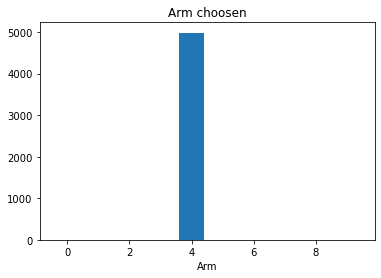

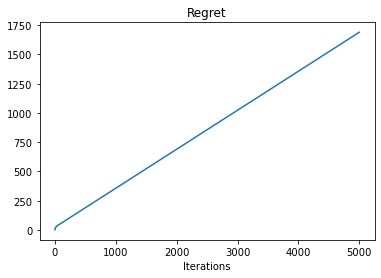

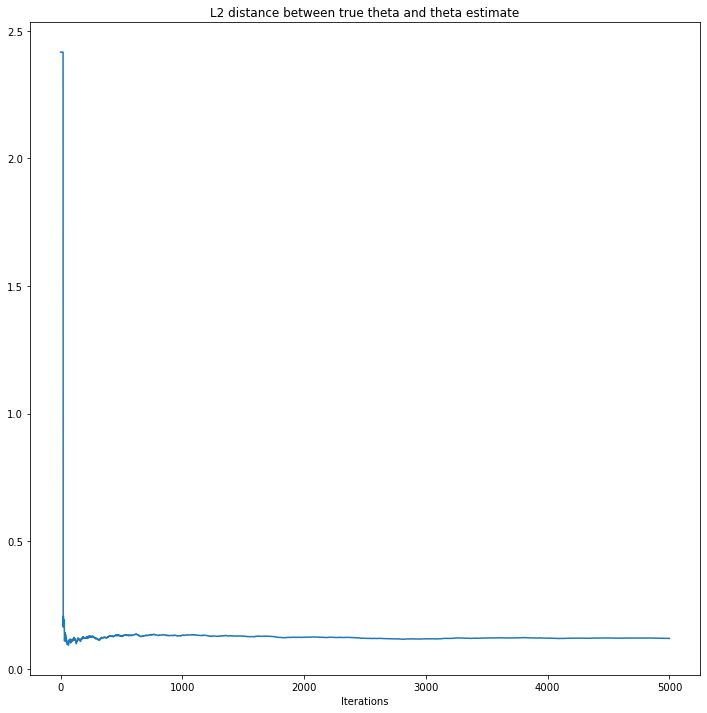

In [73]:
import matplotlib.pyplot as plt
import time

#theta_estimate, N, R, Regret, L2_dist, a = bandit_ts(K, T, phi, true_theta, nu = 1e-2, sigma = 0.5, training_ini = 20, lambda_ = 0.0001)
#theta_estimate, N, R, Regret, L2_dist, a, list_estimates = bandit_ucb(K, T, phi, true_theta, sigma = 0.5, training_ini = 20, lambda_ = 0.0001)
t1 = time.time()
# for _ in range(10): 
#     theta_estimate, N, R, Regret, L2_dist, a, list_estimates = bandit_ucb(K, T, phi, true_theta, alpha = 0.5, sigma = 0.5, training_ini = 20, lambda_ = 0.01)
#     theta_estimate, N, R, Regret, L2_dist, a = bandit(K, T, phi, 0.5*0.5, true_theta, nu = 1e-2, sigma = 0.5, training_ini = 20, lambda_ = 0.0001)
print(t1 - time.time())
theta_estimate, N, R, Regret, L2_dist, a, list_estimates = bandit_ucb(K, T, phi, true_theta, alpha = 10, sigma = 0.1, training_ini = 20, lambda_ = 0.01)
# theta_avg, N, R, Regret, L2_dist, a = bandit_kl(K, T, phi, true_theta, nu = 1e-2, sigma = 0.5, training_ini = 100, lambda_ = 0.0001)
plt.bar(range(len(N)), N)
plt.title('Arm choosen')
plt.xlabel('Arm')
plt.show()


plt.plot(Regret)
plt.title('Regret')
plt.xlabel('Iterations')
plt.show()


plt.figure(figsize=(12,12))
plt.plot(L2_dist[L2_dist>0])
plt.title('L2 distance between true theta and theta estimate')
plt.xlabel('Iterations')
plt.show()


### Grid search thompson sampling

In [11]:
nus = [1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1]
# Cs = [1e-1, 0.25, 0.5, 1, 5]
taus = [10, 25, 50, 100]


regrets = np.zeros((len(nus), len(taus), T + 1))
L2_dists = np.zeros((len(nus), len(taus), T))
Ns = np.zeros((len(nus), len(Cs), len(taus), K))
for idx_nu, nu in enumerate(nus):
    print("nu :", nu)
#     for idx_C, C in enumerate(Cs):
#         print("C :", C)
    for idx_tau, training_ini in enumerate(taus):
        print("training_ini :", training_ini)
        list_Regret, list_N, list_l2 = [], [], []
        for _ in range(10):
            theta_estimate, N, R, Regret, L2_dist, a = bandit_ts(K, T, phi, true_theta, nu = nu, sigma = 0.5, training_ini = training_ini, lambda_ = 0.01)
#                 theta_estimate, N, R, Regret, L2_dist, a = bandit_ts(K, T, phi, C = C, true_theta = true_theta, nu = nu, sigma = 0.5, trainingini = 20, lambda = 0.01)
            list_Regret.append(Regret)
            list_N.append(N)
            list_l2.append(L2_dist)
        regret = np.mean(list_Regret, axis = 0)
        n = np.mean(list_N, axis = 0)
        l2 = np.mean(list_l2, axis = 0)

        regrets[idx_nu, idx_tau, :] = regret
        Ns[idx_nu, idx_tau, :] = n
        L2_dists[idx_nu, idx_tau, :] = l2


nu : 0.0001
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 0.001
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 0.01
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 0.5
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 0.1
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 1
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100


In [ ]:
np.save('ts_bandits_regrets', regrets)
np.save('ts_bandits_l2_dist', L2_dists)
np.save('ts_bandits_Ns', Ns)

### Grid search KL

In [38]:
nus = [1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1]
# Cs = [1e-1, 0.25, 0.5, 1, 5]
taus = [10, 25, 50, 100]


regrets = np.zeros((len(nus), len(taus), T + 1))
L2_dists = np.zeros((len(nus), len(taus), T))
Ns = np.zeros((len(nus), len(Cs), len(taus), K))
for idx_nu, nu in enumerate(nus):
    print("nu :", nu)
#     for idx_C, C in enumerate(Cs):
#         print("C :", C)
    for idx_tau, training_ini in enumerate(taus):
        print("training_ini :", training_ini)
        list_Regret, list_N, list_l2 = [], [], []
        for _ in range(10):
            theta_estimate, N, R, Regret, L2_dist, a = bandit_kl(K, T, phi, true_theta, nu = nu, sigma = 0.5, training_ini = training_ini, lambda_ = 0.01)
#                 theta_estimate, N, R, Regret, L2_dist, a = bandit_ts(K, T, phi, C = C, true_theta = true_theta, nu = nu, sigma = 0.5, trainingini = 20, lambda = 0.01)
            list_Regret.append(Regret)
            list_N.append(N)
            list_l2.append(L2_dist)
        regret = np.mean(list_Regret, axis = 0)
        n = np.mean(list_N, axis = 0)
        l2 = np.mean(list_l2, axis = 0)

        regrets[idx_nu, idx_tau, :] = regret
        Ns[idx_nu, idx_tau, :] = n
        L2_dists[idx_nu, idx_tau, :] = l2

nu : 0.0001
training_ini : 10


<ipython-input-5-aada74015c9a>:10: RuntimeWarning: divide by zero encountered in double_scalars
  I[j] = mu[j] + np.sqrt(2*sigma**2*np.log(1 + t*np.log(t)**2) / N[j])


training_ini : 25
training_ini : 50
training_ini : 100
nu : 0.001
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 0.01
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 0.1
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 0.5
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100
nu : 1
training_ini : 10
training_ini : 25
training_ini : 50
training_ini : 100


In [ ]:
np.save('kl_bandits_regrets', regrets)
np.save('kl_bandits_l2_dist', L2_dists)
np.save('kl_bandits_Ns', Ns)

### Grid search LinUCB

In [136]:
# nus = [1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1]
Cs = [1e-1, 0.25, 0.5, 1, 5]
# taus = [10, 25, 50, 100]


regrets = np.zeros((len(Cs), T + 1))
L2_dists = np.zeros((len(Cs), T))
Ns = np.zeros((len(nus), len(Cs), len(taus), K))
# for idx_nu, nu in enumerate(nus):
#     print("nu :", nu)
for idx_C, C in enumerate(Cs):
    print("C :", C)
#     for idx_tau, training_ini in enumerate(taus):
#         print("training_ini :", training_ini)
    list_Regret, list_N, list_l2 = [], [], []
    for _ in range(10):
#             theta_estimate, N, R, Regret, L2_dist, a = bandit_ts(K, T, phi, true_theta, nu = nu, sigma = 0.5, training_ini = training_ini, lambda_ = 0.01)
        theta_estimate, N, R, Regret, L2_dist, a, list_estimates =bandit_ucb(K, T, phi, true_theta, alpha = C, sigma = 0.5, training_ini = 10, lambda_ = 0.01)
        #                 theta_estimate, N, R, Regret, L2_dist, a = bandit_ts(K, T, phi, C = C, true_theta = true_theta, nu = nu, sigma = 0.5, trainingini = 20, lambda = 0.01)
        list_Regret.append(Regret)
        list_N.append(N)
        list_l2.append(L2_dist)
    regret = np.mean(list_Regret, axis = 0)
    n = np.mean(list_N, axis = 0)
    l2 = np.mean(list_l2, axis = 0)

    regrets[idx_C, :] = regret
    Ns[idx_C, :] = n
    L2_dists[idx_C :] = l2

C : 0.1
C : 0.25
C : 0.5
C : 1
C : 5


In [108]:
%timeit bandit_ucb(K, T, phi, true_theta, alpha = C, sigma = 0.5, training_ini = 20, lambda_ = 0.01)

3.18 s ± 59.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [139]:
np.save('ucb_bandits_regrets', regrets)
np.save('ucb_bandits_l2_dist', L2_dists)
np.save('ucb_bandits_Ns', Ns)

### Grid search BGE

In [ ]:
regrets = np.zeros((len(nus), len(Cs), len(taus), T + 1))
L2_dists = np.zeros((len(nus), len(Cs), len(taus), T))
Ns = np.zeros((len(nus), len(Cs), len(taus), K))
for idx_nu, nu in enumerate(nus):
    print("nu :", nu)
    for idx_C, C in enumerate(Cs):
        print("C :", C)
        for idx_tau, training_ini in enumerate(taus):
            print("training_ini :", training_ini)
            list_Regret, list_N, list_l2 = [], [], []
            for _ in range(10):
                theta_estimate, N, R, Regret, L2_dist, a = bandit(K, T, phi, C = C, true_theta = true_theta, nu = nu, sigma = 0.5, training_ini = training_ini, lambda_ = 0.01)
                list_Regret.append(Regret)
                list_N.append(N)
                list_l2.append(L2_dist)
            regret = np.mean(list_Regret, axis = 0)
            n = np.mean(list_N, axis = 0)
            l2 = np.mean(list_l2, axis = 0)

            regrets[idx_nu, idx_C, idx_tau, :] = regret
            Ns[idx_nu, idx_C, idx_tau, :] = n
            L2_dists[idx_nu, idx_C, idx_tau, :] = l2

In [ ]:
np.save('bge_bandits_regrets', regrets)
np.save('bge_bandits_l2_dist', L2_dists)
np.save('bge_bandits_Ns', Ns)

In [109]:
%timeit bandit(K, T, phi, C = C, true_theta = true_theta, nu = nu, sigma = 0.5, training_ini = training_ini, lambda_ = 0.01)

579 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [130]:
T_list = [1000, 2000, 5000, 10000, 15000]
n_run = 10
time_list_bge2 = np.zeros((len(T_list), n_run))

for i in range(len(T_list)):
    for n in range(n_run):
        print('time t = {} - n_run = {}'.format(T_list[i], n))
        t0 = time.time()
        theta_estimate, N, R, Regret, L2_dist, a = bandit(K, T_list[i], phi, C = 0.5, true_theta = true_theta, nu = nu, sigma = 0.5, training_ini = training_ini, lambda_ = 0.01)
        t1 = time.time()
        time_list_bge2[i, n] = t1 - t0

time t = 1000 - n_run = 0
time t = 1000 - n_run = 1
time t = 1000 - n_run = 2
time t = 1000 - n_run = 3
time t = 1000 - n_run = 4
time t = 1000 - n_run = 5
time t = 1000 - n_run = 6
time t = 1000 - n_run = 7
time t = 1000 - n_run = 8
time t = 1000 - n_run = 9
time t = 2000 - n_run = 0
time t = 2000 - n_run = 1
time t = 2000 - n_run = 2
time t = 2000 - n_run = 3
time t = 2000 - n_run = 4
time t = 2000 - n_run = 5
time t = 2000 - n_run = 6
time t = 2000 - n_run = 7
time t = 2000 - n_run = 8
time t = 2000 - n_run = 9
time t = 5000 - n_run = 0
time t = 5000 - n_run = 1
time t = 5000 - n_run = 2
time t = 5000 - n_run = 3
time t = 5000 - n_run = 4
time t = 5000 - n_run = 5
time t = 5000 - n_run = 6
time t = 5000 - n_run = 7
time t = 5000 - n_run = 8
time t = 5000 - n_run = 9
time t = 10000 - n_run = 0
time t = 10000 - n_run = 1
time t = 10000 - n_run = 2
time t = 10000 - n_run = 3
time t = 10000 - n_run = 4
time t = 10000 - n_run = 5
time t = 10000 - n_run = 6
time t = 10000 - n_run = 7
time

In [121]:
T_list = [1000, 2000, 5000, 10000, 15000]
n_run = 10
time_list_ucb = np.zeros((len(T_list), n_run))

for i in range(len(T_list)):
    for n in range(n_run):
        print('time t = {} - n_run = {}'.format(T_list[i], n))
        t0 = time.time()
        theta_estimate, N, R, Regret, L2_dist, a, list_estimates =bandit_ucb(K, T_list[i], phi, true_theta, alpha = 0.5, sigma = 0.5, training_ini = 20, lambda_ = 0.01)
        t1 = time.time()
        time_list_bge[i, n] = t1 - t0

time t = 1000 - n_run = 0
time t = 1000 - n_run = 1
time t = 1000 - n_run = 2
time t = 1000 - n_run = 3
time t = 1000 - n_run = 4
time t = 1000 - n_run = 5
time t = 1000 - n_run = 6
time t = 1000 - n_run = 7
time t = 1000 - n_run = 8
time t = 1000 - n_run = 9
time t = 2000 - n_run = 0
time t = 2000 - n_run = 1
time t = 2000 - n_run = 2
time t = 2000 - n_run = 3
time t = 2000 - n_run = 4
time t = 2000 - n_run = 5
time t = 2000 - n_run = 6
time t = 2000 - n_run = 7
time t = 2000 - n_run = 8
time t = 2000 - n_run = 9
time t = 5000 - n_run = 0
time t = 5000 - n_run = 1
time t = 5000 - n_run = 2
time t = 5000 - n_run = 3
time t = 5000 - n_run = 4
time t = 5000 - n_run = 5
time t = 5000 - n_run = 6
time t = 5000 - n_run = 7
time t = 5000 - n_run = 8
time t = 5000 - n_run = 9
time t = 10000 - n_run = 0
time t = 10000 - n_run = 1
time t = 10000 - n_run = 2
time t = 10000 - n_run = 3
time t = 10000 - n_run = 4
time t = 10000 - n_run = 5
time t = 10000 - n_run = 6
time t = 10000 - n_run = 7
time

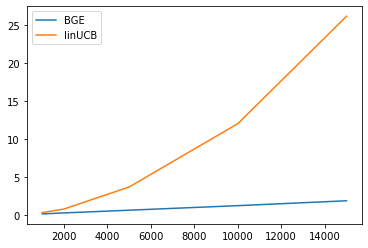

In [132]:
plt.plot(T_list, np.mean(time_list_bge2, axis = 1), label = 'BGE')
plt.plot(T_list, np.mean(time_list_bge, axis = 1), label = 'linUCB')
plt.legend();

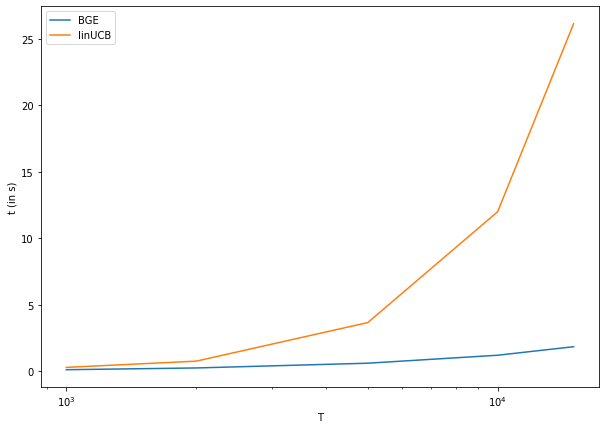

In [141]:
plt.figure(figsize=(10,7))
plt.semilogx(T_list, np.mean(time_list_bge2, axis = 1), label = 'BGE')
plt.semilogx(T_list, np.mean(time_list_bge, axis = 1), label = 'linUCB')
plt.xlabel('T')
plt.ylabel('t (in s)')
plt.legend();

In [129]:
np.mean(time_list_ucb, axis = 1)

array([0., 0., 0., 0., 0.])